In [18]:
import numpy as np
import tensorflow.keras
from tensorflow.keras.models import Sequential , Model
from tensorflow.keras.layers import Input , RepeatVector , TimeDistributed  , GRU , Bidirectional , LSTM , Dense
from tensorflow.keras import regularizers
from tensorflow.keras.utils import Sequence
import os
import pickle
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
from tensorflow.keras.models import model_from_json
from gensim.models.word2vec import Word2Vec

gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        # 프로그램 시작시에 메모리 증가가 설정되어야만 합니다
        print(e)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [19]:
class DataSequence(Sequence):
    def __init__(self, x_set, batch_size, shuffle=True):
        self.x = x_set
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.x))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, fn_list):
        data_files = []
        for fn in fn_list:
            try:
                with open(fn , 'rb') as f:
                    data_files.append(pickle.load(f))
            except:
                with open('error_pickles.txt','a') as f:
                    f.write(fn + '\n')
        data_files = np.array(data_files)
        return data_files
    
    def __len__(self):
        return int(np.ceil(len(self.x) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        batch_x = self.__data_generation(self.x[indexes])
        #print(batch_x.shape)
        return batch_x, batch_x

In [5]:
def get_latent_vec(model , SAVEPATH,filename):
    data = load_pickle(filename)
    vec = model.predict(np.array([data])).reshape(16)
    with open(os.path.join(SAVEPATH,os.path.basename(filename).split('.')[0]+'.txt'),'w') as f:
        f.write(str(vec))         

In [6]:
def get_edit_cosine(result_dic):
    x_data = []
    y_data = []
    sorted_dic = sorted(result_dic.items() , key=lambda x:x[0])
    for i in sorted_dic:
        x_data.append(i[0])
        y_data.append(i[1])
    return x_data , y_data , sorted_dic

In [7]:
def load_pickle(filename):
    with open(filename , 'rb') as f:
        return pickle.load(f)


In [8]:
from numpy import dot
from numpy.linalg import norm
import numpy as np
def cos_sim(A, B):
    return dot(A, B)/(norm(A)*norm(B))

In [16]:
maxlen = 16
word_vector = 64
inputs = Input(shape=(maxlen , word_vector))
encoded = LSTM(32 , return_sequences=True , activation='relu')(inputs)
encoded = LSTM(16, return_sequences=False , activation='relu')(encoded)
decoded = RepeatVector(maxlen)(encoded)
decoded = LSTM(16,return_sequences=True, activation='relu')(decoded)
decoded = LSTM(word_vector ,return_sequences=True, activation='relu')(decoded)
output = TimeDistributed(Dense(word_vector , activation='sigmoid'))(decoded)
sequence_autoencoder = Model(inputs, output)

encoder = Model(inputs, encoded)


In [ ]:
with open('edit_dic.pickle','rb') as f:
    dicc = pickle.load(f)
with open('padding_none.pickle','rb') as f:
    fn_list = pickle.load(f)

In [22]:
train_generator = DataSequence(np.array(fn_list), 4096)

In [24]:
sequence_autoencoder.compile(optimizer='adam' , loss='binary_crossentropy')

In [25]:
encoder.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 16, 64)]          0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 16, 32)            12416     
_________________________________________________________________
lstm_5 (LSTM)                (None, 16)                3136      
Total params: 15,552
Trainable params: 15,552
Non-trainable params: 0
_________________________________________________________________


In [26]:
sequence_autoencoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 16, 64)]          0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 16, 32)            12416     
_________________________________________________________________
lstm_5 (LSTM)                (None, 16)                3136      
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 16, 16)            0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 16, 16)            2112      
_________________________________________________________________
lstm_7 (LSTM)                (None, 16, 64)            20736     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 16, 64)            4160

In [39]:
sequence_autoencoder.fit(train_generator , epochs=8 , verbose=1)

  ...
    to  
  ['...']
Train for 679 steps
Epoch 1/8
679/679 [==============================] - 202s 298ms/step - loss: 0.6673
Epoch 2/8
679/679 [==============================] - 190s 280ms/step - loss: 0.6672
Epoch 3/8
679/679 [==============================] - 191s 281ms/step - loss: 0.6671
Epoch 4/8
679/679 [==============================] - 193s 284ms/step - loss: 0.6671
Epoch 5/8
679/679 [==============================] - 193s 284ms/step - loss: 0.6669
Epoch 6/8
679/679 [==============================] - 197s 289ms/step - loss: 0.6669
Epoch 7/8
679/679 [==============================] - 197s 290ms/step - loss: 0.6668
Epoch 8/8
679/679 [==============================] - 192s 283ms/step - loss: 0.6667


In [29]:
x_data1 , y_data1 , sorted_dic1 = get_edit_cosine(result_dic)

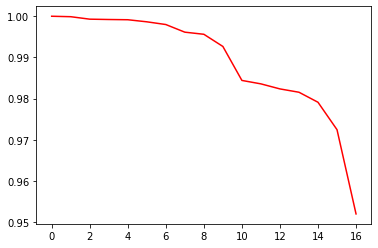

In [30]:
import matplotlib.pyplot as plt
plt.plot(x_data1,y_data1,color='red')
plt.show()

In [33]:
x_data2 , y_data2 , sorted_dic2 = get_edit_cosine(result_dic)

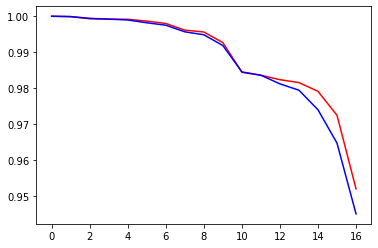

In [34]:
plt.plot(x_data1,y_data1,color='red') #1
plt.plot(x_data2,y_data2,color='blue') # 2
plt.show()

In [37]:
x_data3 , y_data3 , sorted_dic3 = get_edit_cosine(result_dic)

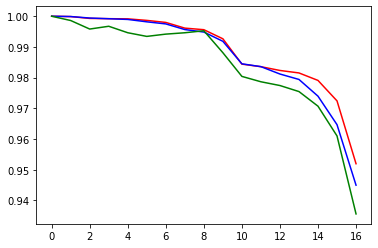

In [38]:
plt.plot(x_data1,y_data1,color='red') #1
plt.plot(x_data2,y_data2,color='blue') # 2
plt.plot(x_data3,y_data3,color='green') # 8
plt.show()

In [41]:
x_data4 , y_data4 , sorted_dic4 = get_edit_cosine(result_dic)

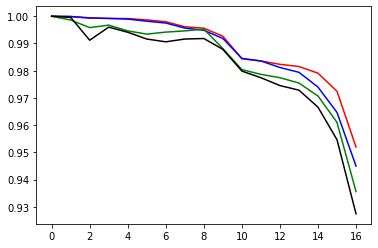

In [42]:
plt.plot(x_data1,y_data1,color='red') #1
plt.plot(x_data2,y_data2,color='blue') # 2
plt.plot(x_data3,y_data3,color='green') # 8
plt.plot(x_data4,y_data4,color='black') # 16
plt.show()

In [44]:
x_data5 , y_data5 , sorted_dic5 = get_edit_cosine(result_dic)

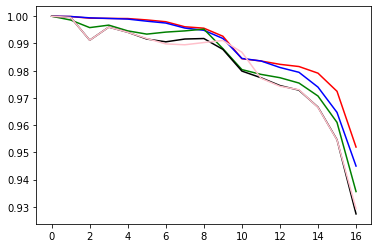

In [45]:
plt.plot(x_data1,y_data1,color='red') #1
plt.plot(x_data2,y_data2,color='blue') # 2
plt.plot(x_data3,y_data3,color='green') # 8
plt.plot(x_data4,y_data4,color='black') # 16_1000개
plt.plot(x_data5,y_data5,color='pink') # 16_5000개
plt.show()